In [4]:
import pandas as pd
import numpy as np
import random

### Loading data

In [ ]:
df1 = pd.read_csv('UK_19.csv')
df2 = pd.read_csv('UK_20.csv')
df3 = pd.read_csv('UK_21.csv')
df4 = pd.read_csv('UK_22.csv')

df5 = pd.read_csv('UK_23.csv')

In [ ]:
df5 = df5[df5['week'] in [27,28,29,30]]
#df5.to_csv('UK_23_July.csv', index = False)

### Preprocessing

Focusing on a smaller area in South-England

In [ ]:
def cut_dataframe(df, lat_min, lat_max, lon_min, lon_max):
    # Filter based on latitude and longitude bounds
    df_filtered = df[
        (df['lats'] >= lat_min) & (df['lats'] <= lat_max) &
        (df['lons'] >= lon_min) & (df['lons'] <= lon_max)
    ]

    # Drop unnecessary columns
    df_filtered = df_filtered.drop(columns=['Unnamed: 0', 'water', 'year'])

    # One-hot encode the 'LC' column
    df_filtered = pd.get_dummies(df_filtered, columns=['LC'], prefix='LC')

    return df_filtered


In [ ]:
lat_min = 50.97
lat_max = 52.1
lon_min = 0
lon_max = 1

df1_cut = cut_dataframe(df1, lat_min, lat_max, lon_min, lon_max)
df2_cut = cut_dataframe(df2, lat_min, lat_max, lon_min, lon_max)
df3_cut = cut_dataframe(df3, lat_min, lat_max, lon_min, lon_max)
df4_cut = cut_dataframe(df4, lat_min, lat_max, lon_min, lon_max)

df5_cut = cut_dataframe(df5, lat_min, lat_max, lon_min, lon_max)

Adding new variables:
- temporal: values from the previous week
- spatial: aggregate of the surrounding values

In [ ]:
def preprocess_temporal_spatial(
    df: pd.DataFrame,
    lat_values: list,
    lon_values: list,
    week_col: str,
    lat_col: str,
    lon_col: str,
    value_columns: list,
    numeric_columns: list,
    binary_columns: list,
    prev_weeks: int = 1
) -> pd.DataFrame:
    df = df.copy()

    # Temporal: previous weeks
    for k in range(1, prev_weeks + 1):
        df_prev = df.copy()
        df_prev[week_col] += k
        suffix = f'_prev{k}'
        for col in value_columns:
            df_prev = df_prev.rename(columns={col: f'{col}{suffix}'})
        df = df.merge(
            df_prev[[lat_col, lon_col, week_col] + [f'{col}{suffix}' for col in value_columns]],
            on=[lat_col, lon_col, week_col],
            how='left'
        )

    # Spatial: neighbor aggregation
    lat_to_idx = {v: i for i, v in enumerate(lat_values)}
    lon_to_idx = {v: i for i, v in enumerate(lon_values)}
    lookup = {
        col: df.set_index([lat_col, lon_col, week_col])[col].to_dict()
        for col in value_columns
    }

    def aggregate_neighbors(row):
        i = lat_to_idx.get(row[lat_col])
        j = lon_to_idx.get(row[lon_col])
        w = row[week_col]
        neighbors = [
            (lat_values[i + di], lon_values[j + dj])
            for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]
            if 0 <= i + di < len(lat_values) and 0 <= j + dj < len(lon_values)
        ]

        out = {}
        for col in numeric_columns:
            vals = [lookup[col].get((lat, lon, w)) for lat, lon in neighbors]
            vals = [v for v in vals if v is not None]
            out[f'{col}_neighbors_mean'] = np.mean(vals) if vals else np.nan

        for col in binary_columns:
            vals = [lookup[col].get((lat, lon, w)) for lat, lon in neighbors]
            vals = [v for v in vals if v in [0, 1]]
            if vals:
                ones, zeros = vals.count(1), vals.count(0)
                if ones > zeros:
                    out[f'{col}_neighbors_majority'] = 1
                elif zeros > ones:
                    out[f'{col}_neighbors_majority'] = 0
                else:
                    out[f'{col}_neighbors_majority'] = random.choice([0, 1])
            else:
                out[f'{col}_neighbors_majority'] = np.nan

        return pd.Series(out)

    df = pd.concat([df, df.apply(aggregate_neighbors, axis=1)], axis=1)

    # Drop unnecessary (static) columns
    df = df.drop(columns = ['EL_prev1','rail_dist_prev1',
       'main_dist_prev1', 'small_dist_prev1', 'city_dist_prev1',
       'non_city_dist_prev1', 'LC_1.0_prev1', 'LC_2.0_prev1', 'LC_3.0_prev1',
       'LC_4.0_prev1', 'LC_5.0_prev1', 'LC_6.0_prev1', 'LC_7.0_prev1',
       'LC_8.0_prev1', 'LC_9.0_prev1','rail_dist_neighbors_mean', 'main_dist_neighbors_mean',
       'small_dist_neighbors_mean', 'city_dist_neighbors_mean',
       'non_city_dist_neighbors_mean'])

    return df

In [ ]:
value_columns = ['NDVI', 'FAPAR', 'LST', 'SWI', 'MT',
       'MXT', 'PA', 'RH', 'WS', 'EL', 'rail_dist', 'main_dist', 'small_dist',
       'city_dist', 'non_city_dist', 'LC_1.0', 'LC_2.0', 'LC_3.0', 'LC_4.0',
       'LC_5.0', 'LC_6.0', 'LC_7.0', 'LC_8.0', 'LC_9.0']
numeric_columns = ['NDVI', 'FAPAR', 'LST', 'SWI', 'MT',
       'MXT', 'PA', 'RH', 'WS', 'EL', 'rail_dist', 'main_dist', 'small_dist',
       'city_dist', 'non_city_dist']
binary_columns = ['LC_1.0', 'LC_2.0', 'LC_3.0', 'LC_4.0',
       'LC_5.0', 'LC_6.0', 'LC_7.0', 'LC_8.0', 'LC_9.0']
target_col = 'ba_bin'

lats = sorted(pd.unique(df4_cut['lats']))
lons = sorted(pd.unique(df4_cut['lons']))

In [ ]:
df1_processed = preprocess_temporal_spatial(
    df=df1_cut,
    lat_values=lats,
    lon_values=lons,
    week_col='week',
    lat_col='lats',
    lon_col='lons',
    value_columns=value_columns,
    numeric_columns=numeric_columns,
    binary_columns=binary_columns,
    prev_weeks=1
)

df2_processed = preprocess_temporal_spatial(
    df=df2_cut,
    lat_values=lats,
    lon_values=lons,
    week_col='week',
    lat_col='lats',
    lon_col='lons',
    value_columns=value_columns,
    numeric_columns=numeric_columns,
    binary_columns=binary_columns,
    prev_weeks=1
)

df3_processed = preprocess_temporal_spatial(
    df=df3_cut,
    lat_values=lats,
    lon_values=lons,
    week_col='week',
    lat_col='lats',
    lon_col='lons',
    value_columns=value_columns,
    numeric_columns=numeric_columns,
    binary_columns=binary_columns,
    prev_weeks=1
)

df4_processed = preprocess_temporal_spatial(
    df=df4_cut,
    lat_values=lats,
    lon_values=lons,
    week_col='week',
    lat_col='lats',
    lon_col='lons',
    value_columns=value_columns,
    numeric_columns=numeric_columns,
    binary_columns=binary_columns,
    prev_weeks=1
)

df5_processed = preprocess_temporal_spatial(
    df=df5_cut,
    lat_values=lats,
    lon_values=lons,
    week_col='week',
    lat_col='lats',
    lon_col='lons',
    value_columns=value_columns,
    numeric_columns=numeric_columns,
    binary_columns=binary_columns,
    prev_weeks=1
)

In [ ]:
#df1_processed.to_csv('UK_19_preproc.csv', index=False)
#df2_processed.to_csv('UK_20_preproc.csv', index=False)
#df3_processed.to_csv('UK_21_preproc.csv', index=False)
#df4_processed.to_csv('UK_22_preproc.csv', index=False)
#df5_processed.to_csv('UK_23_July_preproc.csv', index=False)

Gather all training datasets, undersample the majority class and oversample the minority class with SMOTE + split into training and validation data

In [6]:
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [8]:
input_cols = [
    'NDVI', 'FAPAR', 'LST', 'SWI', 'MT',
       'MXT', 'PA', 'RH', 'WS', 'EL', 'rail_dist', 'main_dist', 'small_dist',
       'city_dist', 'non_city_dist', 'LC_1.0', 'LC_2.0', 'LC_3.0', 'LC_4.0',
       'LC_5.0', 'LC_6.0', 'LC_7.0', 'LC_8.0', 'LC_9.0', 'NDVI_prev1',
       'FAPAR_prev1', 'LST_prev1', 'SWI_prev1', 'MT_prev1', 'MXT_prev1',
       'PA_prev1', 'RH_prev1', 'WS_prev1', 'NDVI_neighbors_mean',
       'FAPAR_neighbors_mean', 'LST_neighbors_mean', 'SWI_neighbors_mean',
       'MT_neighbors_mean', 'MXT_neighbors_mean', 'PA_neighbors_mean',
       'RH_neighbors_mean', 'WS_neighbors_mean', 'EL_neighbors_mean',
       'LC_1.0_neighbors_majority', 'LC_2.0_neighbors_majority',
       'LC_3.0_neighbors_majority', 'LC_4.0_neighbors_majority',
       'LC_5.0_neighbors_majority', 'LC_6.0_neighbors_majority',
       'LC_7.0_neighbors_majority', 'LC_8.0_neighbors_majority',
       'LC_9.0_neighbors_majority']

In [17]:
def balance_and_split(dfs, input_cols, n_class0_samples=8000, random_state=42):
    all_samples = []

    for df in dfs:
        df_class1 = df[df['ba_bin'] == 1]
        df_class0 = df[df['ba_bin'] == 0].sample(n=n_class0_samples, random_state=random_state)
        df_balanced = pd.concat([df_class1, df_class0], axis=0)
        all_samples.append(df_balanced)

    # Combine all datasets and shuffle
    combined_df = pd.concat(all_samples, axis=0).sample(frac=1, random_state=random_state)

    # Extract features and labels
    X = combined_df[input_cols].fillna(0).values
    y = combined_df['ba_bin'].values.astype(int)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply SMOTE
    smote = SMOTE(random_state=random_state)
    X_smote, y_smote = smote.fit_resample(X_scaled, y)

    # Train/validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state=random_state
    )

    return X_train, X_val, y_train, y_val


In [8]:
dfs = [df1_processed, df2_processed, df3_processed, df4_processed]
X_train, X_val, y_train, y_val = balance_and_split(dfs, input_cols)

In [9]:
train_df = pd.DataFrame(X_train, columns=input_cols)
train_df['ba_bin'] = y_train
val_df = pd.DataFrame(X_val, columns=input_cols)
val_df['ba_bin'] = y_val

train_df.to_csv('train_df.csv', index=False)
val_df.to_csv('val_df.csv', index=False)

### Train neural network

#### Model 1

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define the model
mlp1 = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    max_iter=200,
    random_state=42,
    verbose=True
)

# Train the model
mlp1.fit(X_train, y_train)

Iteration 1, loss = 0.17001250
Iteration 2, loss = 0.06381485
Iteration 3, loss = 0.04070626
Iteration 4, loss = 0.02988779
Iteration 5, loss = 0.02343814
Iteration 6, loss = 0.01850639
Iteration 7, loss = 0.01584535
Iteration 8, loss = 0.01335389
Iteration 9, loss = 0.01180847
Iteration 10, loss = 0.01066112
Iteration 11, loss = 0.00852022
Iteration 12, loss = 0.00775563
Iteration 13, loss = 0.00687047
Iteration 14, loss = 0.00703186
Iteration 15, loss = 0.00643579
Iteration 16, loss = 0.00596488
Iteration 17, loss = 0.00583456
Iteration 18, loss = 0.00693711
Iteration 19, loss = 0.00552451
Iteration 20, loss = 0.00394762
Iteration 21, loss = 0.00469188
Iteration 22, loss = 0.00445973
Iteration 23, loss = 0.00457742
Iteration 24, loss = 0.00401752
Iteration 25, loss = 0.00327333
Iteration 26, loss = 0.00351405
Iteration 27, loss = 0.00394304
Iteration 28, loss = 0.00281601
Iteration 29, loss = 0.00355437
Iteration 30, loss = 0.00251369
Iteration 31, loss = 0.00455927
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, verbose=True)

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve

# Predict on validation set
y_pred1 = mlp1.predict(X_val)
y_pred_proba1 = mlp1.predict_proba(X_val)[:, 1]

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred1))
print("\nClassification Report:\n", classification_report(y_val, y_pred1))

roc_auc = roc_auc_score(y_val, y_pred1)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Confusion Matrix:
 [[6369   31]
 [   4 6396]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6400
           1       1.00      1.00      1.00      6400

    accuracy                           1.00     12800
   macro avg       1.00      1.00      1.00     12800
weighted avg       1.00      1.00      1.00     12800

ROC-AUC Score: 0.9973


#### Model 2
Prevent from overfitting:

increase regularization + apply early stopping

In [13]:
# Define the model
mlp2 = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=1e-3,
    max_iter=200,
    random_state=42,
    verbose=True,
    early_stopping=True
)

# Train the model
mlp2.fit(X_train, y_train)

Iteration 1, loss = 0.17972266
Validation score: 0.972266
Iteration 2, loss = 0.07078952
Validation score: 0.985938
Iteration 3, loss = 0.04318477
Validation score: 0.990820
Iteration 4, loss = 0.03174256
Validation score: 0.992969
Iteration 5, loss = 0.02487190
Validation score: 0.994922
Iteration 6, loss = 0.01977475
Validation score: 0.993555
Iteration 7, loss = 0.01625845
Validation score: 0.994922
Iteration 8, loss = 0.01465032
Validation score: 0.994922
Iteration 9, loss = 0.01202986
Validation score: 0.996875
Iteration 10, loss = 0.01107169
Validation score: 0.996289
Iteration 11, loss = 0.00963150
Validation score: 0.996289
Iteration 12, loss = 0.00797682
Validation score: 0.995898
Iteration 13, loss = 0.00870825
Validation score: 0.998047
Iteration 14, loss = 0.00720975
Validation score: 0.995313
Iteration 15, loss = 0.00800771
Validation score: 0.997656
Iteration 16, loss = 0.00559956
Validation score: 0.998242
Iteration 17, loss = 0.00509393
Validation score: 0.998047
Iterat

MLPClassifier(alpha=0.001, early_stopping=True, hidden_layer_sizes=(100, 50),
              random_state=42, verbose=True)

In [14]:
# Predict on validation set
y_pred2 = mlp2.predict(X_val)
y_pred_proba2 = mlp2.predict_proba(X_val)[:, 1]

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred2))
print("\nClassification Report:\n", classification_report(y_val, y_pred2))

roc_auc = roc_auc_score(y_val, y_pred2)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Confusion Matrix:
 [[6360   40]
 [   4 6396]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      6400
           1       0.99      1.00      1.00      6400

    accuracy                           1.00     12800
   macro avg       1.00      1.00      1.00     12800
weighted avg       1.00      1.00      1.00     12800

ROC-AUC Score: 0.9966


### Inference on test set

In [15]:
test_df = pd.read_csv('UK_23_July_preproc.csv')

In [18]:
from sklearn.preprocessing import StandardScaler

X_test = test_df[input_cols].fillna(0).values
y_test = test_df['ba_bin'].values.astype(int)

# Fit scaler
scaler = StandardScaler()
scaler.fit(X_test)
X_test = scaler.transform(X_test)

#### Model 1

In [19]:
y_pred_test = mlp1.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_test)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.7456


In [30]:
import joblib
joblib.dump(mlp1, 'mlp_classifier_model1.pkl')

['/content/drive/My Drive/Thesis/mlp_classifier_model1.pkl']

#### Model 2

In [20]:
y_pred_test2 = mlp2.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_test2)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.7547


In [31]:
joblib.dump(mlp2, 'mlp_classifier_model2.pkl')

['/content/drive/My Drive/Thesis/mlp_classifier_model2.pkl']

### SHAP evaluation

with Kernel SHAP

In [28]:
# Get indices for class 1 and class 0 from the test set
idx_class1 = np.where(y_test == 1)[0]
idx_class0 = np.where(y_test == 0)[0]

# Sample
np.random.seed(42)
idx_class0_sampled = np.random.choice(idx_class0, size=10*len(idx_class1), replace=False)

# Combine indices and shuffle
balanced_indices = np.concatenate([idx_class1, idx_class0_sampled])
np.random.shuffle(balanced_indices)

# Subset the test set
X_explain = X_test[balanced_indices]
y_explain = y_test[balanced_indices]

  0%|          | 0/759 [00:00<?, ?it/s]

<ipython-input-29-f6c68a25b4e7>:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,1], X_explain, feature_names=input_cols)


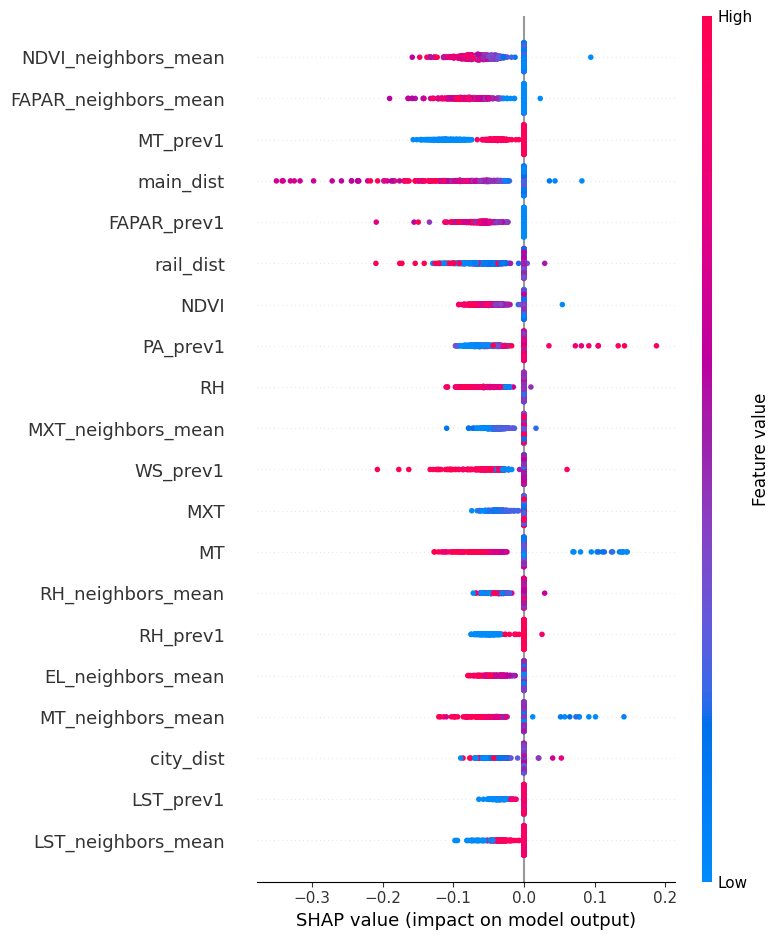

In [29]:
import shap

# Background sample from X_train
X_background = X_train[np.random.choice(X_train.shape[0], 200, replace=False)]

# Define explainer
explainer = shap.KernelExplainer(mlp2.predict_proba, X_background)

# Compute SHAP values
shap_values = explainer.shap_values(X_explain)

# Plot SHAP summary
shap.summary_plot(shap_values[:,:,1], X_explain, feature_names=input_cols)